Experiments on the data treatment from the fitted models

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from SVIModel import SVIModel
import math

folder_path = "E:/OutputParamsFiles/OutputFiles"
files = [entry.name for entry in os.scandir(folder_path) if entry.is_file()]
# Sort files numerically based on their names
files_sorted = sorted(files, key=lambda x: int(x.split()[1].split('.')[0]))
dataFrame = pd.DataFrame(columns = ["QUOTE_UNIXTIME", "EXPIRE_UNIX", "a", "b", "rho", "m", "sigma"])

for i in range(1000):
    file_path = os.path.join(folder_path, files_sorted[i])
    imported_file = pd.read_csv(file_path, sep = ",")
    dataFrame = pd.concat([imported_file, dataFrame])

averages_df = dataFrame.groupby("QUOTE_UNIXTIME", as_index=False)[['a', 'b', 'rho', 'm', 'sigma']].mean()

spot_price = 100
max_strike_spot_distance = 0.20
log_moneyness = np.log(np.linspace(spot_price*(1-max_strike_spot_distance), spot_price*(1+max_strike_spot_distance), 100)/spot_price)
fitted_smile = []

print(dataFrame.head())
print(averages_df.head())

C:\Users\paula\AppData\Local\Temp\ipykernel_7032\2429539108.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataFrame = pd.concat([imported_file, dataFrame])


  QUOTE_UNIXTIME EXPIRE_UNIX         a         b       rho         m     sigma
0     1546625460  1546635600  0.000001  4.758141 -0.950966 -0.022208  0.014306
1     1546625460  1546894800  0.000001  0.657618 -0.990000  0.018718  0.000002
2     1546625460  1547067600  0.000001  0.696758 -0.990000  0.026637  0.000001
3     1546625460  1547240400  0.000001  0.809386 -0.159779  0.047226  0.000001
4     1546625460  1547499600  0.000001  0.675271 -0.103228  0.051068  0.000001
  QUOTE_UNIXTIME         a         b       rho         m     sigma
0     1546439410  0.013219  0.640025  0.054696  0.087487  0.035755
1     1546439460  0.012314  0.684687  0.010272  0.082758  0.026516
2     1546439520  0.010850  0.636477  0.045591  0.092279  0.038214
3     1546439580  0.007485  0.514959 -0.104043  0.098126  0.017335
4     1546439640  0.009160  0.692085 -0.019301  0.089371  0.021515


In [151]:
def plot_rows_against_x(df, x, n_cols = 15, figsize_per_plot=(2, 2)):
    """
    Plots each row of the DataFrame against the same x-axis.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data to plot.
    x (array-like): List, array, or Series to be used as the common x-axis.
    """
        # Calculate overall figure size
    n_rows = math.ceil(df.shape[0] / n_cols)
    total_width = n_cols * figsize_per_plot[0]
    total_height = n_rows * figsize_per_plot[1]

    
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, figsize=(total_width, total_height))  # Subplots configuration

    # Flatten axes for easy iteration (handles 2D axes array)
    axes = axes.flatten()

    # Iterate over rows
    for idx, row in df.iterrows():
        fitted = SVIModel().svi(x, 
                    df['a'][idx],
                    df['b'][idx],
                    df['rho'][idx],
                    df['m'][idx],
                    df['sigma'][idx],
                    )
        axes[idx].plot(x, fitted, marker = 'o')
        axes[idx].set_title(f"{idx}")
        axes[idx].grid(True)
        
# Remove empty subplots if any
    for i in range(df.shape[0], len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

#plot_rows_against_x(dataFrame, log_moneyness)

After visualy checking the fitted smiles let's tray to do some correlation analysis.

In [152]:
dataFrame['term_structure'] = (dataFrame['EXPIRE_UNIX'] - dataFrame['QUOTE_UNIXTIME'])/3600/24/365
#averages_df = averages_df.drop(averages_df.columns[1], axis=1)
print(dataFrame.head())
print(averages_df.head())

  QUOTE_UNIXTIME EXPIRE_UNIX         a         b       rho         m  \
0     1546625460  1546635600  0.000001  4.758141 -0.950966 -0.022208   
1     1546625460  1546894800  0.000001  0.657618 -0.990000  0.018718   
2     1546625460  1547067600  0.000001  0.696758 -0.990000  0.026637   
3     1546625460  1547240400  0.000001  0.809386 -0.159779  0.047226   
4     1546625460  1547499600  0.000001  0.675271 -0.103228  0.051068   

      sigma term_structure  
0  0.014306       0.000322  
1  0.000002       0.008541  
2  0.000001        0.01402  
3  0.000001         0.0195  
4  0.000001       0.027719  
  QUOTE_UNIXTIME         a         b       rho         m     sigma
0     1546439410  0.013219  0.640025  0.054696  0.087487  0.035755
1     1546439460  0.012314  0.684687  0.010272  0.082758  0.026516
2     1546439520  0.010850  0.636477  0.045591  0.092279  0.038214
3     1546439580  0.007485  0.514959 -0.104043  0.098126  0.017335
4     1546439640  0.009160  0.692085 -0.019301  0.089371  

Let's get the correlations

In [153]:
# Step 2: Compute correlation with the other columns
correlation_results = dataFrame[['term_structure', 'a', 'b', 'rho', 'm', 'sigma']].corr()
print(correlation_results)

                term_structure         a         b       rho         m  \
term_structure        1.000000 -0.002702 -0.150216 -0.088403  0.026092   
a                    -0.002702  1.000000  0.001204  0.083094 -0.275423   
b                    -0.150216  0.001204  1.000000  0.229089 -0.325696   
rho                  -0.088403  0.083094  0.229089  1.000000  0.251152   
m                     0.026092 -0.275423 -0.325696  0.251152  1.000000   
sigma                -0.024487  0.459710 -0.062337  0.042865  0.006951   

                   sigma  
term_structure -0.024487  
a               0.459710  
b              -0.062337  
rho             0.042865  
m               0.006951  
sigma           1.000000  


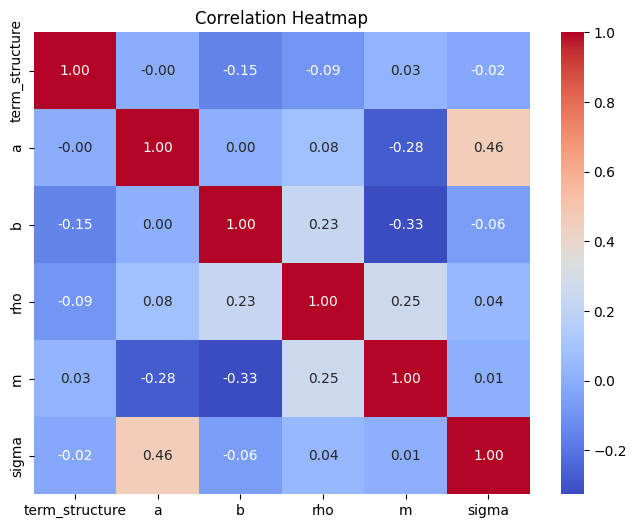

In [154]:
import seaborn as sns
# Assuming 'correlation_matrix' is your correlation matrix
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_results, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Let's analyse the auto-correlation of the params

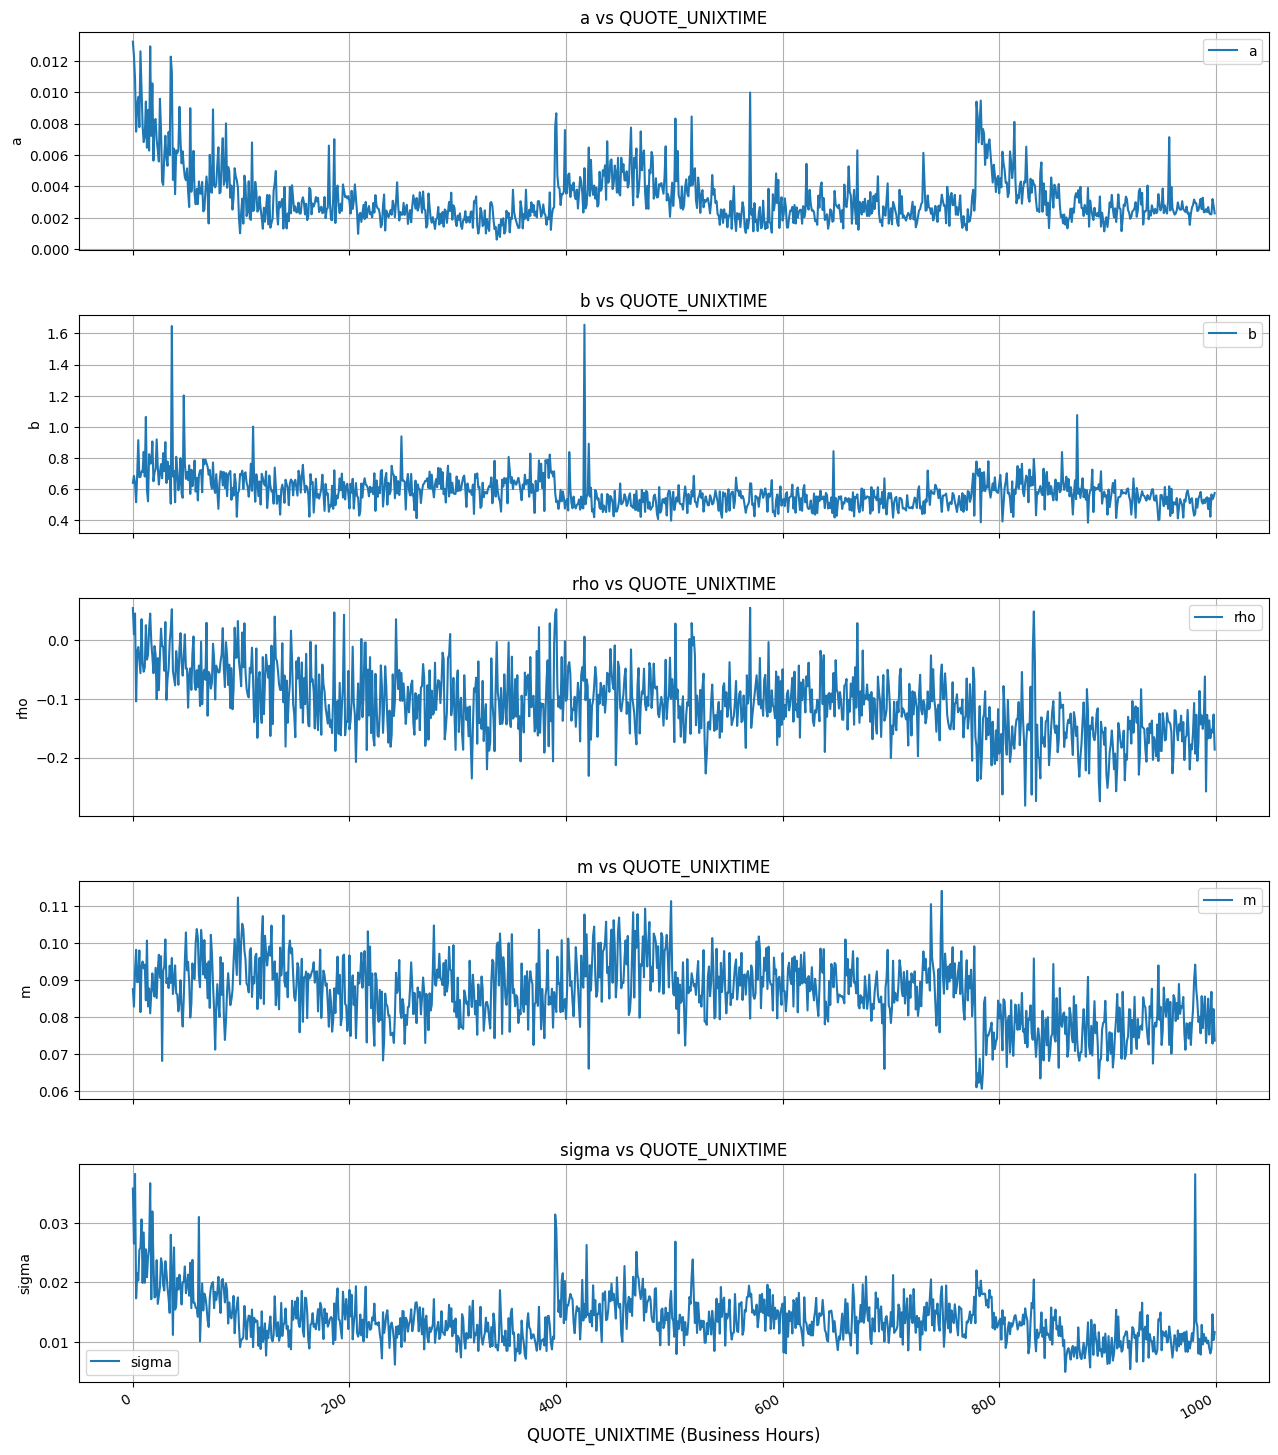

In [155]:
# Convert UNIX time to datetime format
averages_df['QUOTE_UNIXTIME'] = pd.to_datetime(averages_df['QUOTE_UNIXTIME'], unit='s')

# Create a sequential index to replace gaps (business hours only)
averages_df['Business_Hours_Index'] = range(len(averages_df))

# Define Y columns and X (compressed index)
x = averages_df['Business_Hours_Index']

# Define the list of Y-axis columns to plot
y_columns = ['a', 'b', 'rho', 'm', 'sigma']

# Create 5 subplots with a larger figure size
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 18), sharex=True)  # Increased figure size

# Plot each Y column on a separate subplot
for i, col in enumerate(y_columns):
    axes[i].plot(x, averages_df[col], linestyle='-', label=col)
    axes[i].set_title(f"{col} vs QUOTE_UNIXTIME", fontsize=12)
    axes[i].set_ylabel(col, fontsize=10)
    axes[i].grid(True)
    axes[i].legend()

# Adjust x-axis and add more space on the right
plt.subplots_adjust(right=0.95, left=0.1, top=0.95, bottom=0.05, hspace=0.3)  # Adjust spacing
axes[-1].set_xlabel("QUOTE_UNIXTIME (Business Hours)", fontsize=12)

# Format x-axis labels
fig.autofmt_xdate()

# Show the graph
plt.show()

Auto-correlation study function

In [158]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd

def autocorrelation_report_with_ar(df, column_names, lags=5):
    """
    Generate autocorrelation analysis reports and fit AR models if autocorrelation is detected.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_names (list): List of column names to analyze.
    lags (int): Number of lags for ACF, PACF, and AR models. Default is 50.
    """
    for col in column_names:
        print(f"\n{'='*50}\nTime Series Analysis Report for '{col}'\n{'='*50}")
        
        # Extract the time series
        time_series = df[col].dropna()
        
        # Durbin-Watson Test
        dw_stat = durbin_watson(time_series)
        print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
        if dw_stat < 2:
            print("=> Positive autocorrelation detected.")
            autocorrelated = True
        elif dw_stat > 2:
            print("=> Negative autocorrelation detected.")
            autocorrelated = True
        else:
            print("=> No significant autocorrelation detected.")
            autocorrelated = False
        
        # ADF Test for stationarity
        adf_result = adfuller(time_series)
        print(f"\nADF Test Results:")
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        if adf_result[1] <= 0.05:
            print("=> The time series is stationary.")
        else:
            print("=> The time series is non-stationary.")
        
        # Plot ACF
        print("\nAutocorrelation Function (ACF):")
        plt.figure(figsize=(10, 4))
        plot_acf(time_series, lags=lags, title=f"ACF for {col}")
        plt.show()
        
        # Plot PACF
        print("Partial Autocorrelation Function (PACF):")
        plt.figure(figsize=(10, 4))
        plot_pacf(time_series, lags=lags, title=f"PACF for {col}")
        plt.show()

        # Fit AR model if autocorrelation is detected
        if autocorrelated:
            print("\nFitting an AR Model...")
            ar_model = AutoReg(time_series, lags=lags).fit()
            print("\nAR Model Summary:")
            print(ar_model.summary())

            # Plot AR model predictions
            predictions = ar_model.predict(start=0, end=len(time_series)-1)
            plt.figure(figsize=(10, 4))
            plt.plot(time_series, label="Original Time Series")
            plt.plot(predictions, label="AR Model Predictions", linestyle='--')
            plt.title(f"AR Model Fit for '{col}'")
            plt.legend()
            plt.show()
        else:
            print("\nNo AR model was fitted as no significant autocorrelation was detected.")
        
        print(f"\n{'='*50}\nReport Completed for '{col}'\n{'='*50}")



Time Series Analysis Report for 'a'
Durbin-Watson Statistic: 0.1545
=> Positive autocorrelation detected.

ADF Test Results:
ADF Statistic: -4.6455
p-value: 0.0001
=> The time series is stationary.

Autocorrelation Function (ACF):


<Figure size 1000x400 with 0 Axes>

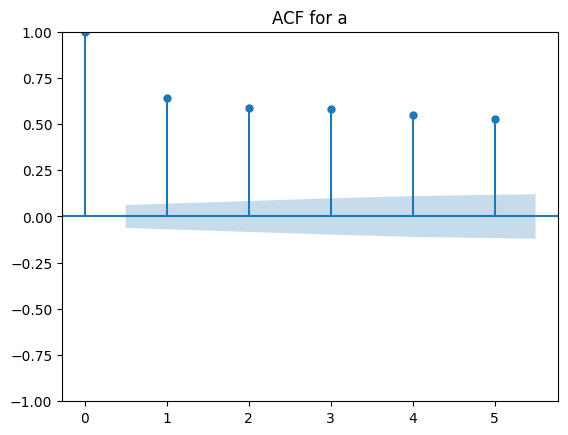

Partial Autocorrelation Function (PACF):


<Figure size 1000x400 with 0 Axes>

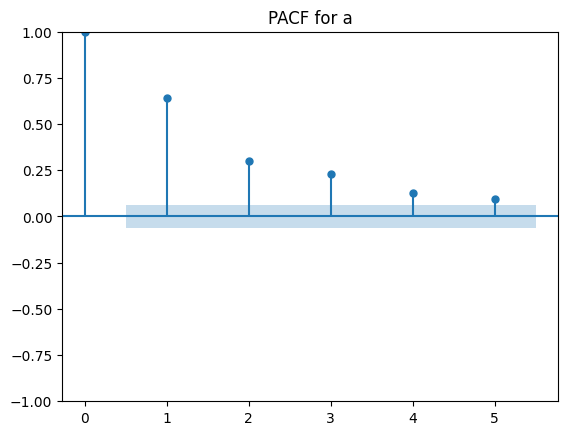


Fitting an AR Model...

AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                      a   No. Observations:                 1000
Model:                     AutoReg(5)   Log Likelihood                5295.467
Method:               Conditional MLE   S.D. of innovations              0.001
Date:              mar., 17 déc. 2024   AIC                         -10576.933
Time:                        20:21:25   BIC                         -10542.614
Sample:                             5   HQIC                        -10563.886
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005   9.33e-05      5.565      0.000       0.000       0.001
a.L1           0.2872      0.032      9.114      0.000       0.225       0.349
a.L2     

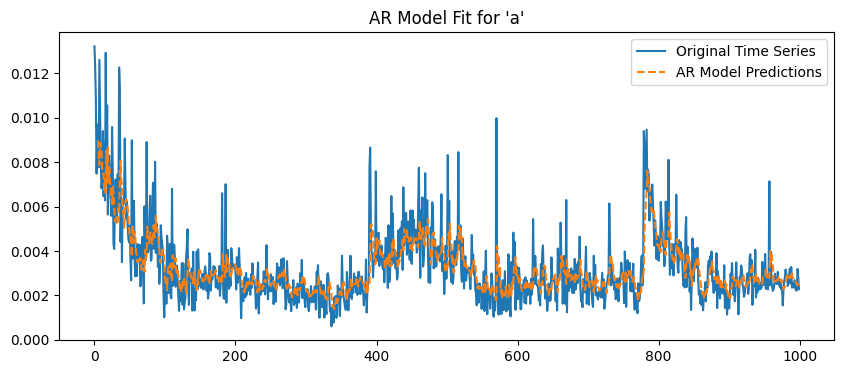


Report Completed for 'a'

Time Series Analysis Report for 'b'
Durbin-Watson Statistic: 0.0497
=> Positive autocorrelation detected.

ADF Test Results:
ADF Statistic: -3.0627
p-value: 0.0294
=> The time series is stationary.

Autocorrelation Function (ACF):


<Figure size 1000x400 with 0 Axes>

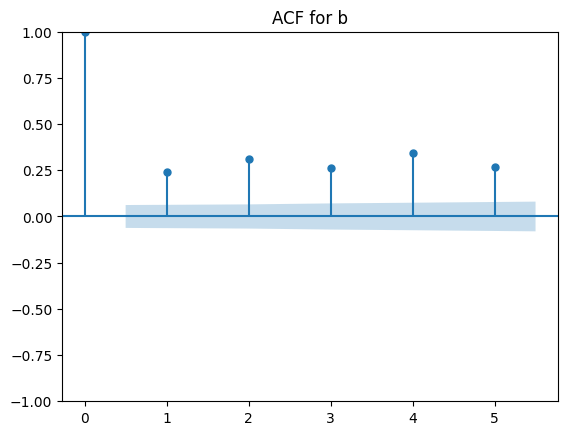

Partial Autocorrelation Function (PACF):


<Figure size 1000x400 with 0 Axes>

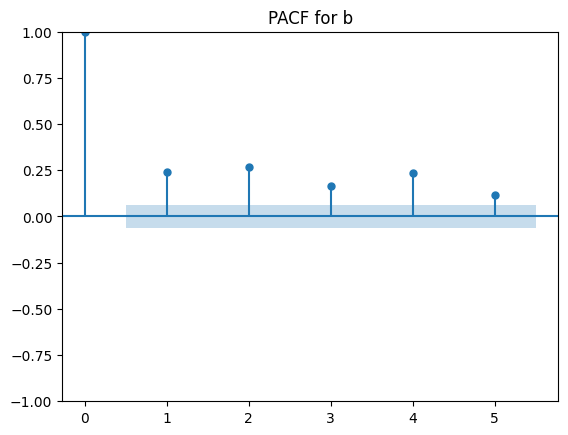


Fitting an AR Model...

AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                      b   No. Observations:                 1000
Model:                     AutoReg(5)   Log Likelihood                 926.877
Method:               Conditional MLE   S.D. of innovations              0.095
Date:              mar., 17 déc. 2024   AIC                          -1839.754
Time:                        20:21:25   BIC                          -1805.435
Sample:                             5   HQIC                         -1826.708
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1834      0.026      7.183      0.000       0.133       0.233
b.L1           0.0648      0.031      2.059      0.039       0.003       0.127
b.L2     

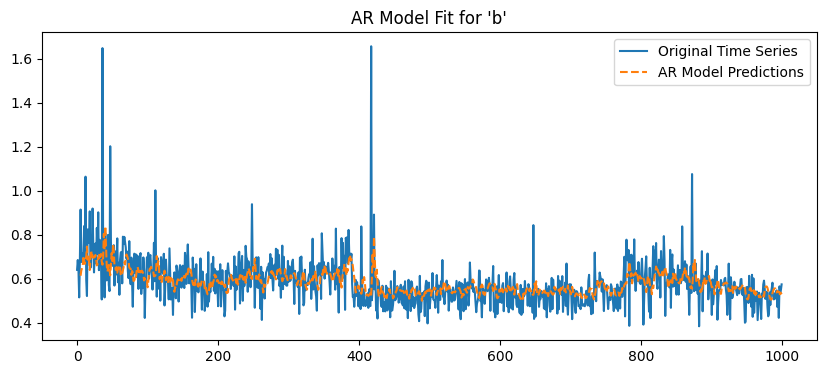


Report Completed for 'b'

Time Series Analysis Report for 'rho'
Durbin-Watson Statistic: 0.2835
=> Positive autocorrelation detected.

ADF Test Results:
ADF Statistic: -2.9341
p-value: 0.0415
=> The time series is stationary.

Autocorrelation Function (ACF):


<Figure size 1000x400 with 0 Axes>

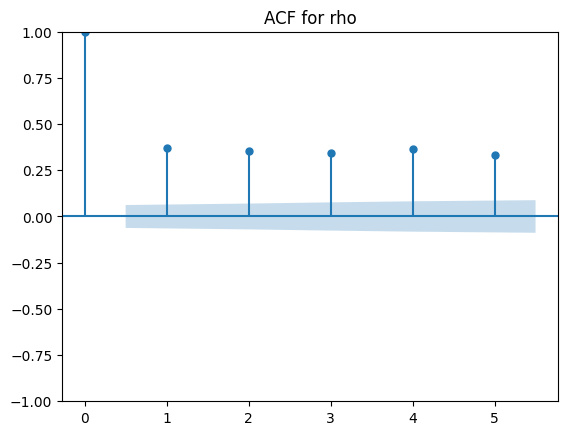

Partial Autocorrelation Function (PACF):


<Figure size 1000x400 with 0 Axes>

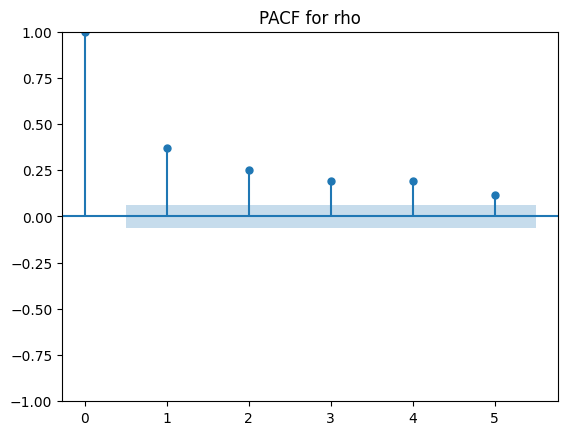


Fitting an AR Model...

AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                    rho   No. Observations:                 1000
Model:                     AutoReg(5)   Log Likelihood                1577.666
Method:               Conditional MLE   S.D. of innovations              0.050
Date:              mar., 17 déc. 2024   AIC                          -3141.331
Time:                        20:21:26   BIC                          -3107.012
Sample:                             5   HQIC                         -3128.284
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0300      0.004     -6.705      0.000      -0.039      -0.021
rho.L1         0.1649      0.031      5.237      0.000       0.103       0.227
rho.L2   

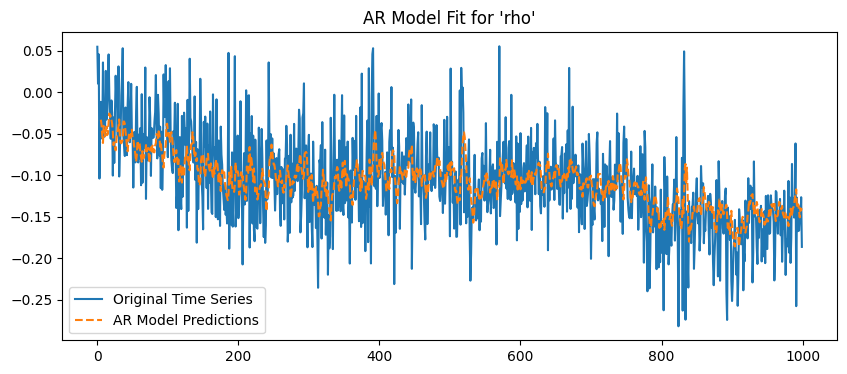


Report Completed for 'rho'

Time Series Analysis Report for 'm'
Durbin-Watson Statistic: 0.0104
=> Positive autocorrelation detected.

ADF Test Results:
ADF Statistic: -3.3849
p-value: 0.0115
=> The time series is stationary.

Autocorrelation Function (ACF):


<Figure size 1000x400 with 0 Axes>

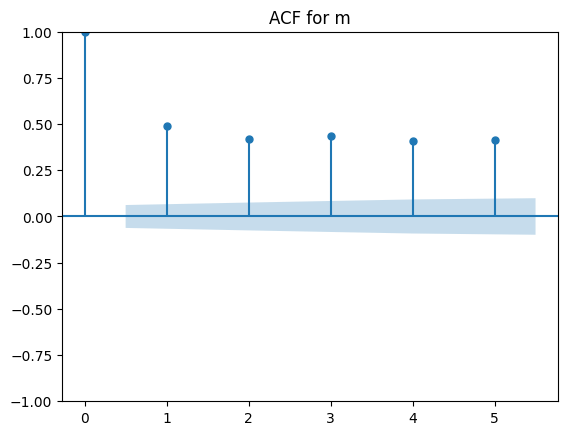

Partial Autocorrelation Function (PACF):


<Figure size 1000x400 with 0 Axes>

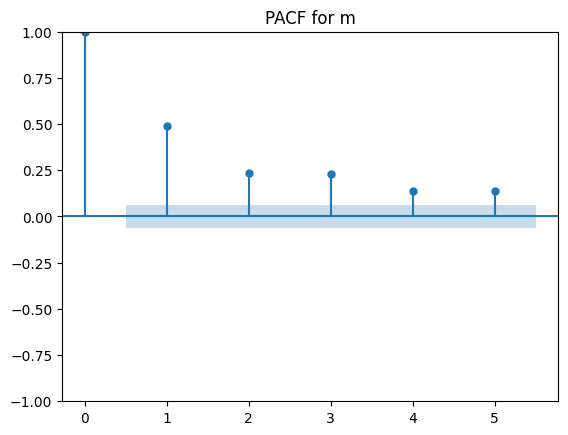


Fitting an AR Model...

AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                      m   No. Observations:                 1000
Model:                     AutoReg(5)   Log Likelihood                3510.317
Method:               Conditional MLE   S.D. of innovations              0.007
Date:              mar., 17 déc. 2024   AIC                          -7006.634
Time:                        20:21:26   BIC                          -6972.315
Sample:                             5   HQIC                         -6993.587
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.003      6.411      0.000       0.013       0.025
m.L1           0.2688      0.031      8.557      0.000       0.207       0.330
m.L2     

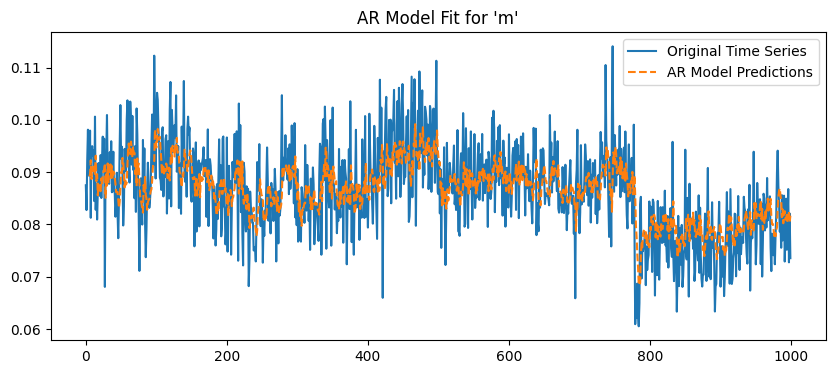


Report Completed for 'm'

Time Series Analysis Report for 'sigma'
Durbin-Watson Statistic: 0.0827
=> Positive autocorrelation detected.

ADF Test Results:
ADF Statistic: -4.2675
p-value: 0.0005
=> The time series is stationary.

Autocorrelation Function (ACF):


<Figure size 1000x400 with 0 Axes>

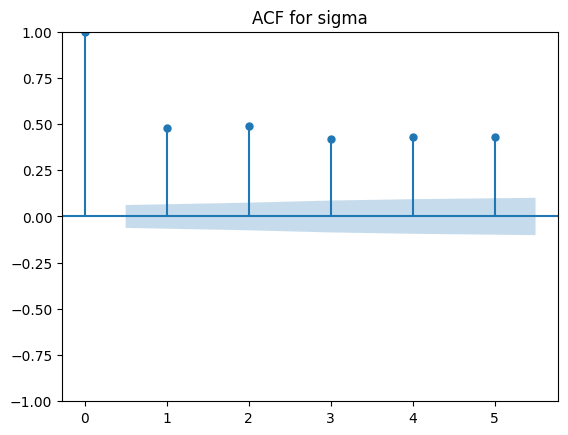

Partial Autocorrelation Function (PACF):


<Figure size 1000x400 with 0 Axes>

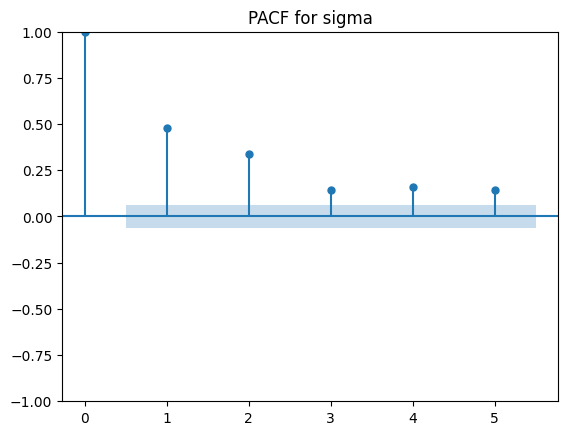


Fitting an AR Model...

AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                  sigma   No. Observations:                 1000
Model:                     AutoReg(5)   Log Likelihood                4316.419
Method:               Conditional MLE   S.D. of innovations              0.003
Date:              mar., 17 déc. 2024   AIC                          -8618.838
Time:                        20:21:26   BIC                          -8584.519
Sample:                             5   HQIC                         -8605.791
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.000      6.375      0.000       0.002       0.004
sigma.L1       0.1978      0.031      6.317      0.000       0.136       0.259
sigma.L2 

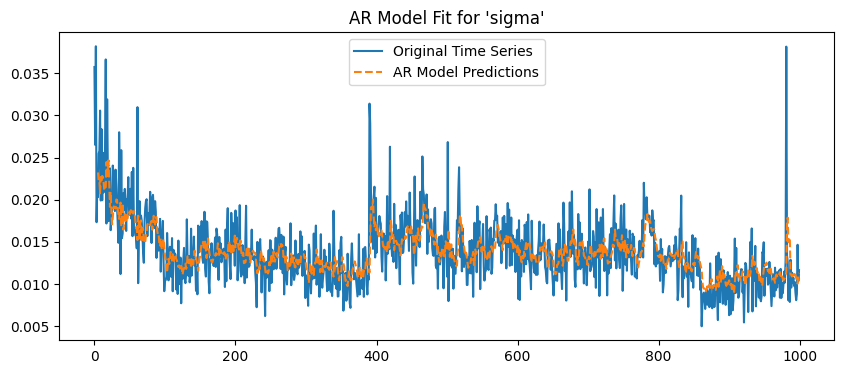


Report Completed for 'sigma'


In [159]:
# Example usage
columns_to_test = ['a', 'b', 'rho', 'm', 'sigma']
autocorrelation_report_with_ar(averages_df, columns_to_test)

Test for how much the models are better than a moving average

In [168]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import arma_order_select_ic
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def compare_ar_vs_ma(df, column_names, ma_window= 10, max_manual_lags=10):
    """
    Compare AR models with a Moving Average (MA) model for specified columns.
    Handles NaN values and generates analysis reports and plots.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_names (list): List of column names to analyze.
    ma_window (int): Window size for Moving Average.
    max_manual_lags (int): Max lags for AR model selection.
    """
    for col in column_names:
        print(f"\n{'='*50}\nTime Series Analysis Report for '{col}'\n{'='*50}")
        
        # Extract the time series and drop NaNs
        time_series = df[col].dropna()

        # Durbin-Watson Test
        dw_stat = durbin_watson(time_series)
        print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
        autocorrelated = dw_stat < 2 or dw_stat > 2
        
        # ADF Test for stationarity
        adf_result = adfuller(time_series)
        print(f"\nADF Test Results:")
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        
        # Fit AR Model with best lag selection
        print("\nFitting AR Model (Automatic Lag Selection)...")
        order_result = arma_order_select_ic(time_series, max_ar=max_manual_lags, ic='aic', trend='n')
        best_lag = order_result.aic_min_order[0]
        print(f"Best Lag (AR) based on AIC: {best_lag}")

        ar_model = AutoReg(time_series, lags=best_lag).fit()
        ar_predictions = ar_model.predict(start=0, end=len(time_series)-1)

        # Drop NaN values for RMSE calculation
        valid_idx = ~np.isnan(ar_predictions)
        ar_rmse = np.sqrt(mean_squared_error(time_series[valid_idx], ar_predictions[valid_idx]))
        print(f"AR Model RMSE: {ar_rmse:.4f}")

        # Moving Average Model
        print("\nFitting Moving Average Model...")
        ma_predictions = time_series.rolling(window=ma_window, min_periods=1).mean()

        # Drop NaN values for RMSE calculation
        valid_idx_ma = ~np.isnan(ma_predictions)
        ma_rmse = np.sqrt(mean_squared_error(time_series[valid_idx_ma], ma_predictions[valid_idx_ma]))
        print(f"Moving Average RMSE: {ma_rmse:.4f}")

        # Plot the results
        plt.figure(figsize=(12, 6))
        plt.plot(time_series, label="Original Time Series", color="blue")
        plt.plot(ar_predictions, label="AR Model Predictions", linestyle="--", color="green")
        plt.plot(ma_predictions, label="Moving Average Predictions", linestyle="--", color="red")
        plt.title(f"AR Model vs Moving Average for '{col}'")
        plt.legend()
        plt.show()

        # Final comparison
        print(f"\nComparison for '{col}':")
        print(f"AR Model RMSE: {ar_rmse:.4f}")
        print(f"Moving Average RMSE: {ma_rmse:.4f}")
        if ar_rmse < ma_rmse:
            print("=> AR Model performs better.")
        else:
            print("=> Moving Average performs better.")

        print(f"\n{'='*50}\nReport Completed for '{col}'\n{'='*50}")




Time Series Analysis Report for 'a'
Durbin-Watson Statistic: 0.1545

ADF Test Results:
ADF Statistic: -4.6455
p-value: 0.0001

Fitting AR Model (Automatic Lag Selection)...


c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

Best Lag (AR) based on AIC: 1
AR Model RMSE: 0.0013

Fitting Moving Average Model...
Moving Average RMSE: 0.0010


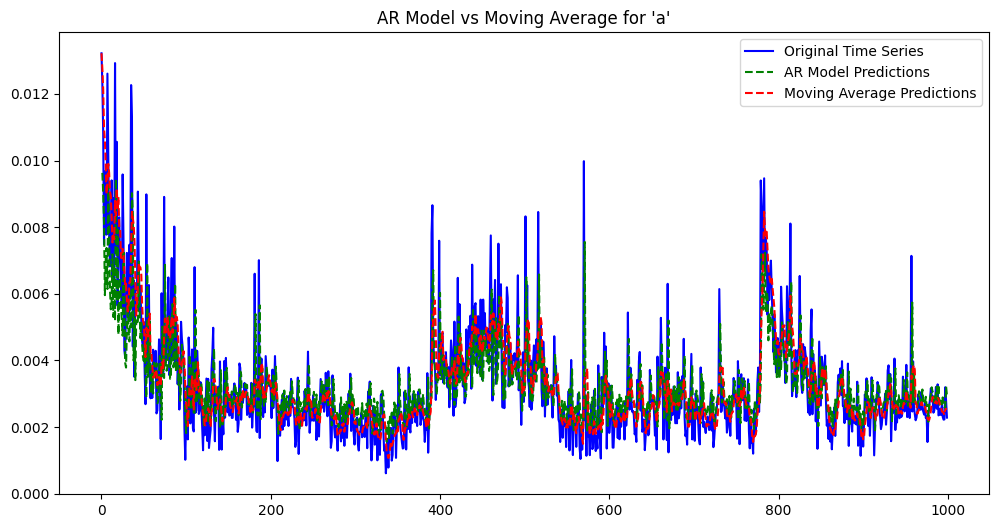


Comparison for 'a':
AR Model RMSE: 0.0013
Moving Average RMSE: 0.0010
=> Moving Average performs better.

Report Completed for 'a'

Time Series Analysis Report for 'b'
Durbin-Watson Statistic: 0.0497

ADF Test Results:
ADF Statistic: -3.0627
p-value: 0.0294

Fitting AR Model (Automatic Lag Selection)...


c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Best Lag (AR) based on AIC: 2
AR Model RMSE: 0.1000

Fitting Moving Average Model...
Moving Average RMSE: 0.0797


c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


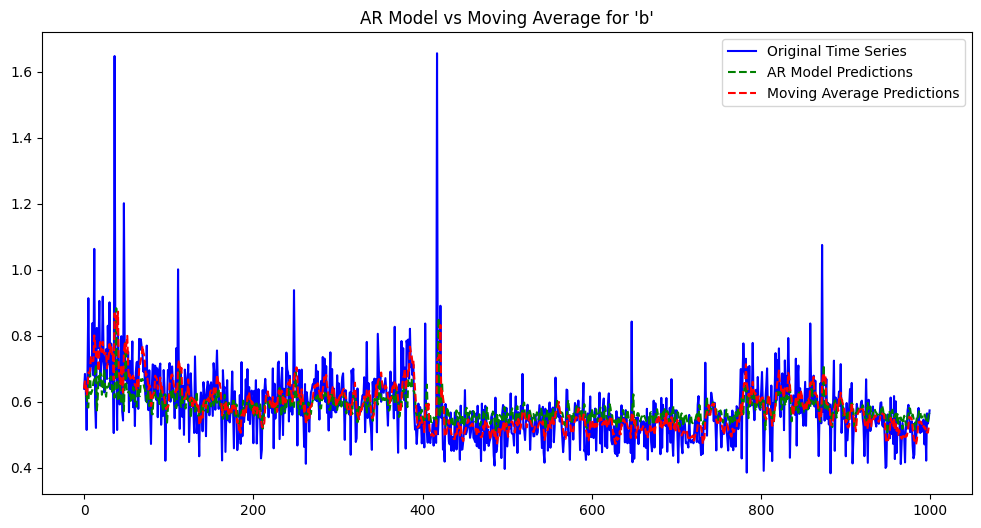


Comparison for 'b':
AR Model RMSE: 0.1000
Moving Average RMSE: 0.0797
=> Moving Average performs better.

Report Completed for 'b'

Time Series Analysis Report for 'rho'
Durbin-Watson Statistic: 0.2835

ADF Test Results:
ADF Statistic: -2.9341
p-value: 0.0415

Fitting AR Model (Automatic Lag Selection)...


c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

Best Lag (AR) based on AIC: 1
AR Model RMSE: 0.0537

Fitting Moving Average Model...
Moving Average RMSE: 0.0413


c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


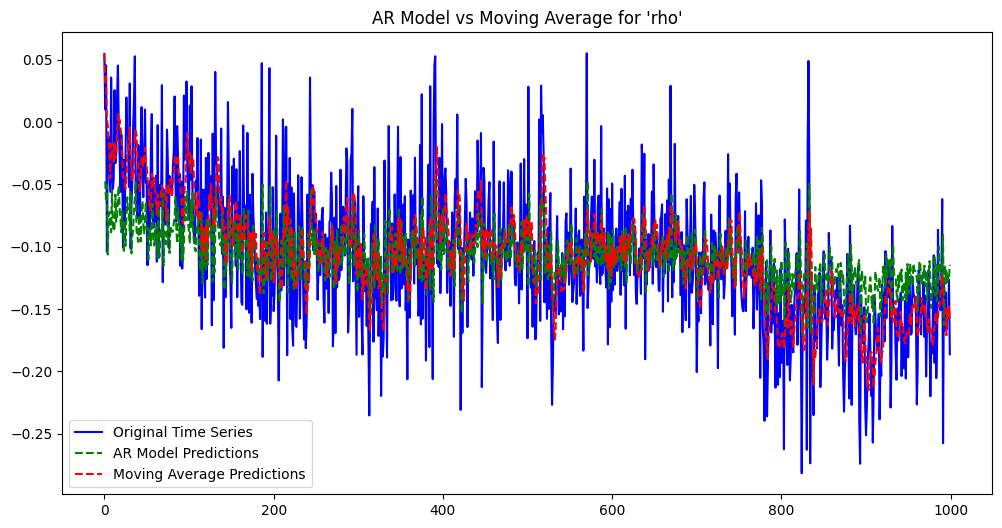


Comparison for 'rho':
AR Model RMSE: 0.0537
Moving Average RMSE: 0.0413
=> Moving Average performs better.

Report Completed for 'rho'

Time Series Analysis Report for 'm'
Durbin-Watson Statistic: 0.0104

ADF Test Results:
ADF Statistic: -3.3849
p-value: 0.0115

Fitting AR Model (Automatic Lag Selection)...


c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

Best Lag (AR) based on AIC: 3
AR Model RMSE: 0.0072

Fitting Moving Average Model...
Moving Average RMSE: 0.0059


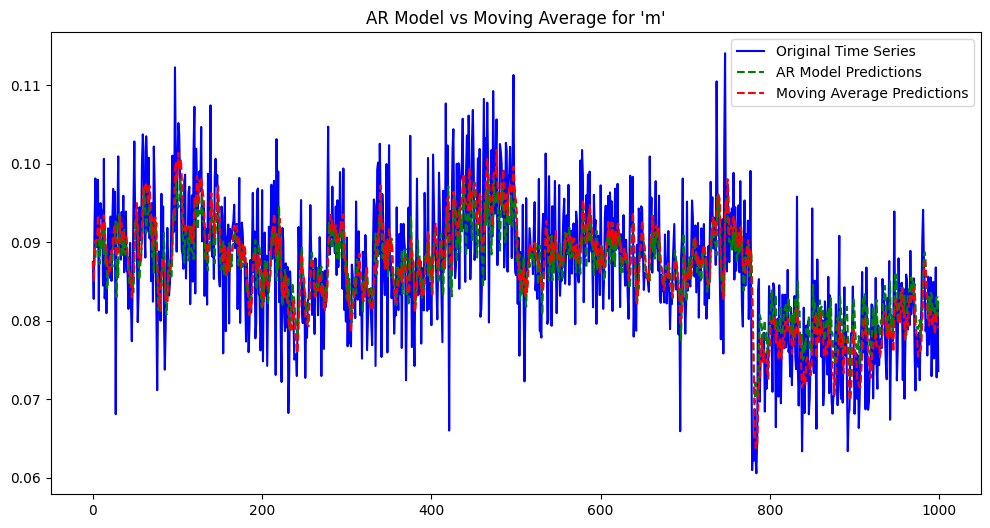


Comparison for 'm':
AR Model RMSE: 0.0072
Moving Average RMSE: 0.0059
=> Moving Average performs better.

Report Completed for 'm'

Time Series Analysis Report for 'sigma'
Durbin-Watson Statistic: 0.0827

ADF Test Results:
ADF Statistic: -4.2675
p-value: 0.0005

Fitting AR Model (Automatic Lag Selection)...


c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\paula\OneDrive\Documents\Big Data Package\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

Best Lag (AR) based on AIC: 2
AR Model RMSE: 0.0033

Fitting Moving Average Model...
Moving Average RMSE: 0.0027


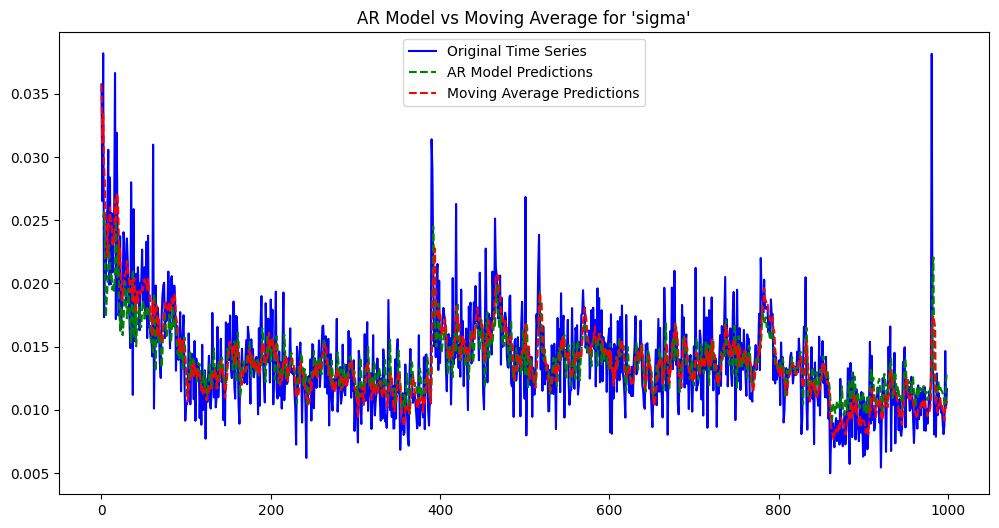


Comparison for 'sigma':
AR Model RMSE: 0.0033
Moving Average RMSE: 0.0027
=> Moving Average performs better.

Report Completed for 'sigma'


In [169]:
# Example usage
columns_to_test = ['a', 'b', 'rho', 'm', 'sigma']
compare_ar_vs_ma(averages_df, columns_to_test, ma_window=5, max_manual_lags=10)
